# New York City 311 Service Requests

In this project, I will analyse which New York City boroughs have recieved the most incident service requests based on the agency involved. The dataset used is a subset from the 311 Service Requests from 2010 to Present dataset on the NYC Open Data website (https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9).

First, let's import our packages.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's take a look at our data.

In [6]:
df = pd.read_csv("nyc_311_data_subset.csv")
df.head()

C:\Users\Jonthan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unique Key,Created Date,Closed Date,Agency,Incident Zip,Borough,Latitude,Longitude
0,1,10/11/2016 11:53:00 AM,10/11/2016 12:00:00 PM,DSNY,NaN,QUEENS,NaN,NaN
1,1,10/11/2016 11:36:00 AM,10/11/2016 12:00:00 PM,DSNY,NaN,QUEENS,NaN,NaN
2,1,10/11/2016 11:36:00 AM,10/11/2016 12:00:00 PM,DSNY,NaN,QUEENS,NaN,NaN
3,1,10/11/2016 12:39:00 PM,10/11/2016 12:39:00 PM,DSNY,NaN,QUEENS,NaN,NaN
4,1,10/11/2016 12:18:00 PM,10/11/2016 12:18:00 PM,DSNY,NaN,QUEENS,NaN,NaN


In [9]:
df.info()
#comparing the number of entries to the non-null values in addition to the data type of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971063 entries, 0 to 971062
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unique Key    971063 non-null  int64  
 1   Created Date  971063 non-null  object 
 2   Closed Date   882944 non-null  object 
 3   Agency        971063 non-null  object 
 4   Incident Zip  911140 non-null  object 
 5   Borough       971063 non-null  object 
 6   Latitude      887284 non-null  float64
 7   Longitude     887284 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 59.3+ MB


To get any statistical significance out of the data, we have to get rid of the null values in it.
Therefore, data cleaning is essential in better understanding our data.

## Data Cleaning

In this step, I noticed that the zip codes were not properly formatted: in strings, with more or less than five digits, or extremes. I dropped all rows with null values and unspecified boroughs. Using feature engineering, I created a new column to calculate the time it takes to complete a service request for each incident. I took all these and placed it inside a function that applys these data cleaning processes to the dataset.

In [11]:
def read_311_data(datafile):
    import pandas as pd
    import numpy as np
    
    #Add the fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 19999:
            return np.NaN
        return str(input_zip)
    
    #Read the file
    df = pd.read_csv(datafile,index_col='Unique Key')
    
    #fix the zip
    df['Incident Zip'] = df['Incident Zip'].apply(fix_zip)
    
    #drop all rows that have any nans in them (note the easier syntax!)
    
    df = df.dropna(how='any')
    
    #get rid of unspecified boroughs
    df = df[df['Borough'] != 'Unspecified']
    
    #Convert times to datetime and create a processing time column
    
    import datetime
    df['Created Date'] = df['Created Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    df['Closed Date'] = df['Closed Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    df['processing_time'] =  df['Closed Date'] - df['Created Date']
    
    #Finally, get rid of negative processing times and return the final data frame
    
    df = df[df['processing_time']>=datetime.timedelta(0,0,0)]
    
    return df

In [12]:
datafile = "nyc_311_data_subset.csv"
data = read_311_data(datafile)

C:\Users\Jonthan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [13]:
data.head()

,Created Date,Closed Date,Agency,Incident Zip,Borough,Latitude,Longitude,processing_time
Unique Key,,,,,,,,
1,2016-09-01 00:33:42,2016-09-16 01:06:56,DCA,10001,MANHATTAN,40.744790,-73.988834,15 days 00:33:14
1,2016-09-01 20:16:24,2016-09-10 18:08:25,HPD,11691,QUEENS,40.600554,-73.750704,8 days 21:52:01
1,2016-09-01 12:17:00,2016-09-07 12:00:00,DSNY,11211,BROOKLYN,40.704925,-73.962007,5 days 23:43:00
1,2016-09-01 12:10:22,2016-09-10 14:23:44,HPD,10027,MANHATTAN,40.812322,-73.955338,9 days 02:13:22
1,2016-09-01 12:32:32,2016-09-11 02:03:37,HPD,10452,BRONX,40.839529,-73.922534,9 days 13:31:05


## Incidents by Borough

Now that our data is cleaned, we can group the data by borough and plot a bar chart of incident count.

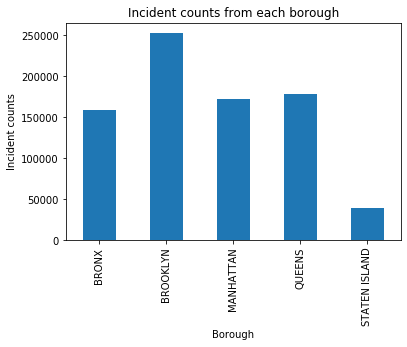

In [30]:
%matplotlib inline
borough_group = data.groupby('Borough')
borough_group.size().plot(kind='bar')
#kind can be 'hist', 'scatter'
plt.ylabel('Incident counts')
plt.title('Incident counts from each borough')
plt.show()